In [271]:
import numpy as np
import cv2
import random
import sys
import matplotlib.pyplot as plt
import face_recognition
import math 

%matplotlib inline

**Define functions**

In [264]:
# Read points from text file
def readPoints(path):
    # Create an array of points.
    points = []
    # Read points
    with open(path) as file:
        for line in file:
            x, y = line.split()
            points.append((int(x), int(y)))

    return points

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
                         flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, alpha):

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]), (t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1] +
                                              r[3], r[0]:r[0]+r[2]] * (1 - mask) + imgRect * mask



def faceImage(frame, index=0):
    face_location = face_recognition.face_locations(frame)[index]
    top, right, bottom, left = face_location
    return frame[top:bottom, left:right]

**Delaunay functions**

In [260]:
# Check if a point is inside a rectangle
def rect_contains(rect, point):
    if point[0] < rect[0]:
        return False
    elif point[1] < rect[1]:
        return False
    elif point[0] > rect[2]:
        return False
    elif point[1] > rect[3]:
        return False
    return True

# Draw a point
def draw_point(img, p, color):
    cv2.circle(img, p, 2, color, cv2.cv.FILLED, cv2.LINE_AA, 0)


# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color):

    triangleList = subdiv.getTriangleList()
    size = img.shape
    r = (0, 0, size[1], size[0])

    for t in triangleList:

        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3):

            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)


# Draw voronoi diagram
def draw_voronoi(img, subdiv):

    (facets, centers) = subdiv.getVoronoiFacetList([])

    for i in xrange(0, len(facets)):
        ifacet_arr = []
        for f in facets[i]:
            ifacet_arr.append(f)

        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(
            0, 255), random.randint(0, 255))

        cv2.fillConvexPoly(img, ifacet, color, cv2.LINE_AA, 0)
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1, cv2.LINE_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]),
                   3, (0, 0, 0), cv2.cv.FILLED, cv2.LINE_AA, 0)

**Extract face landmarks**

In [261]:
# get extend points to make sure we got convex hull
def get_extend_points(img):
    height, width, _ = img.shape
    middle_height = round(height/2)
    middle_width = round(width/2)
    bottom = height - 1
    right = width - 1
    extend_points=[
        (0, 0),    # left, top
        (0, middle_height),  # left, middle-height 
        (0, bottom),   # left, bottom 
        (middle_width, bottom), # middle-width, bottom 
        (right, bottom), # right, bottom 
        (right, middle_height), # right, middle-height
        (right, 0),   # right, top
        (middle_width, 0)   # middle-width, top
    ]
    return extend_points

features_ordered = [
    'chin',
    'left_eyebrow',
    'right_eyebrow',
    'nose_bridge',
    'nose_tip',
    'left_eye',
    'right_eye',
#     'top_lip',
    'bottom_lip',    
]

# Find all facial features in all the faces in the image
def face_points(image, debug=False):
    face_landmarks_list = face_recognition.face_landmarks(image)
    points = []
    for face_landmarks in face_landmarks_list:
        
        # Print the location of each facial feature in this image
        for facial_feature in features_ordered:
            feature_points = face_landmarks[facial_feature]            
            points += feature_points
            if debug:
                print("The {} in this face has the following points: {}" 
                      .format(facial_feature, feature_points))
    points += get_extend_points(image)
    return points


def get_subdiv(rect, points):
     
    # Create an instance of Subdiv2D
    subdiv = cv2.Subdiv2D(rect)
    # Insert points into subdiv
    for p in points :
        try:
            subdiv.insert(p)
        except:
            pass
            
    return subdiv


#calculate delanauy triangle
def calculate_delaunay_triangles(rect, points):
    #create subdiv
    subdiv = get_subdiv(rect, points) 
    
    triangle_list = subdiv.getTriangleList();
    
    delaunay_tri = []
    
    pt = []    
        
    for t in triangle_list:        
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])   
        
        pt.extend([pt1, pt2, pt3])
        
        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunay_tri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunay_tri
    

In [262]:
def blending(background, foreGroundImage):
    """Alpha blending."""

    # Split png foreground image
    b, g, r, a = cv2.split(foreGroundImage)

    # Save the foregroung RGB content into a single object
    foreground = cv2.merge((b, g, r))

    # Save the alpha information into a single Mat
    alpha = cv2.merge((a, a, a))

    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)
    alpha = alpha.astype(float)/255

    # Perform alpha blending
    foreground = cv2.multiply(alpha, foreground)
    background = cv2.multiply(1.0 - alpha, background)
    outImage = cv2.add(foreground, background)
    return outImage

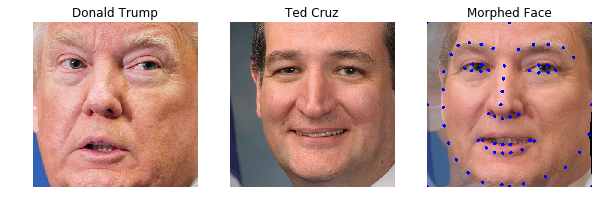

In [274]:
filename1 = 'donald_trump.jpg'
filename2 = 'ted_cruz.jpg'
alpha = 0.5

# Read images
img1 = face_recognition.load_image_file(filename1)
img2 = face_recognition.load_image_file(filename2)

# Extract faces
img1 = faceImage(img1)
img2 = faceImage(img2)

# Read array of corresponding points
points1 = face_points(img1, False)
points2 = face_points(img2, False)

points = []

# scale to same size
img_h, img_w, _ = img1.shape
img2 = cv2.resize(img2, (img_w, img_h)) 

# Convert Mat to float data type
img1_arr = np.float32(img1)
img2_arr = np.float32(img2)

# print(img1.shape, img2.shape)

# Compute weighted average point coordinates
for i in range(0, len(points1)):
    x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
    y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
    points.append((x, y))

# Allocate space for final output
imgMorph = np.zeros((img_h, img_w, 3), dtype=img1.dtype)

rect = (0 ,0, img_w, img_h)
delaunay_tri = calculate_delaunay_triangles(rect, points)
    
for (x, y, z) in delaunay_tri:
    t1 = [points1[x], points1[y], points1[z]]
    t2 = [points2[x], points2[y], points2[z]]
    t = [points[x], points[y], points[z]]        
    
    # Morph one triangle at a time.
    morphTriangle(img1_arr, img2_arr, imgMorph, t1, t2, t, alpha)

# print(imgMorph)

# # Display Result
# frame = np.uint8(imgMorph)
frame = np.uint8(imgMorph)
# masked_img = cv2.add(frame, img1)
for point in points:
    cv2.circle(frame, (round(point[0]),round(point[1])), 4, (0,0,255), -1)
    
# figure first to prevent redraw plot
known_face_images=[img1, img2, frame]
known_face_names=['Donald Trump', 'Ted Cruz', 'Morphed Face']
columns = 3
rows = math.ceil(len(known_face_names) / columns)
_, ax_tables = plt.subplots(rows, columns, figsize=[10,5])

for index, name in enumerate(known_face_names):
    face_img = known_face_images[index]
    row = math.floor(index / columns)
    name = known_face_names[index]
    column = index % columns
    if rows > 1 :
        ax = ax_tables[row][column]
    else :
        ax = ax_tables[column]
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(face_img)
